In [3]:
import simulation as sim
import matplotlib.pyplot as plt
import numpy as np

sim.main_exe = '../build/doble_socket'

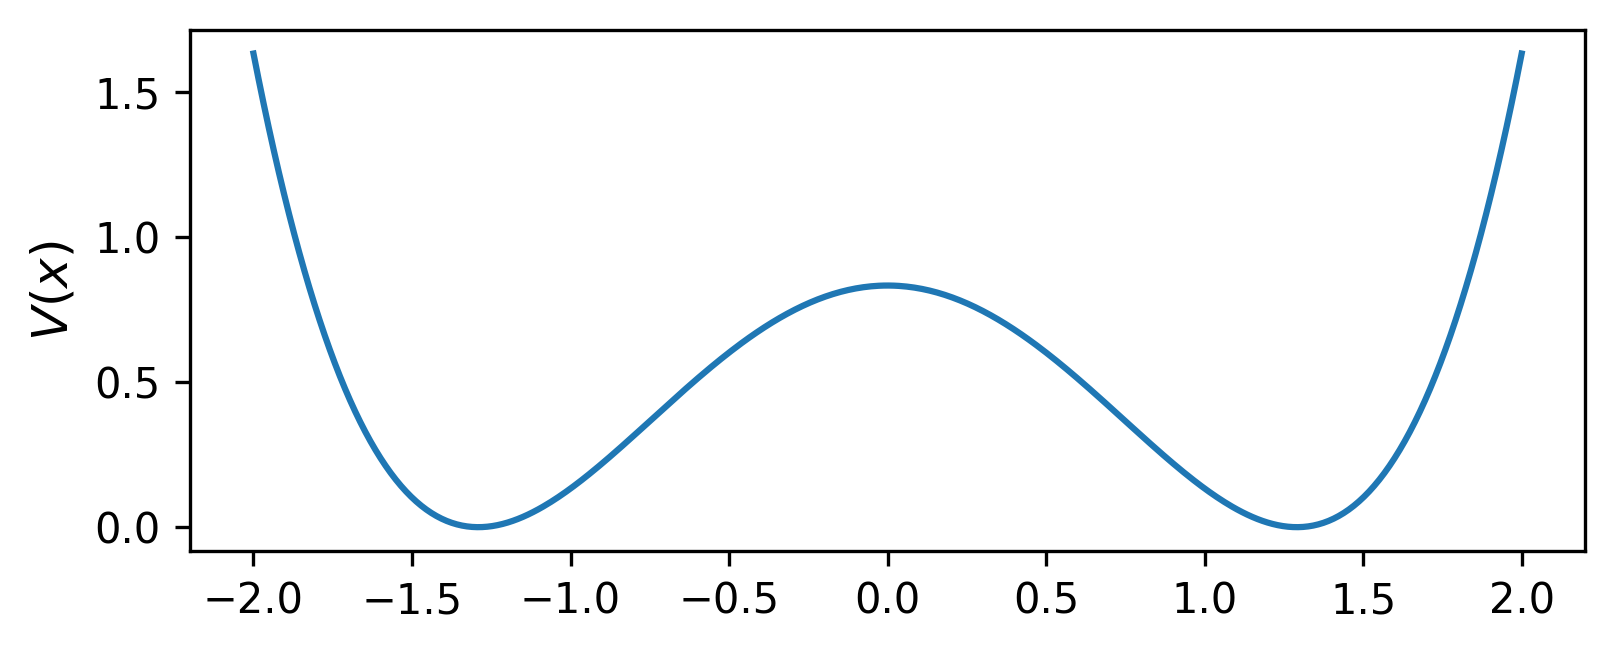

In [4]:
a = 1; g = 0.3

def potential(xx):
    x2 = xx*xx
    return -x2*a+g*x2*x2

xxx = np.linspace(-2, +2, 500)
yyy = potential(xxx)+1/4/g
plt.figure(figsize=(6,2.3), dpi=300)
plt.plot(xxx, yyy)
#plt.xlabel('$x$', fontsize=12)
plt.ylabel('$V(x)$', fontsize=12)
plt.show()

In [42]:
# Simulazione

s = sim.Span('../sim_data/test_024/')
params = {
    'f': 100,
    #'b': 500,
    't': 500000,
    's': 'RANDOM',
    'd': 0.8,
    'a': a,
    'g': g,
    'p': 0.15,
}

bb = np.logspace(np.log10(80), np.log10(300), 6)
if not s.runned:
    s.run('b', bb, **params)

from pprint import pprint
pprint(s.simulations[0].kwargs, indent=4)

Span.run tqdm


100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


{   'a': '1',
    'b': '5e+09',
    'd': '1',
    'f': '400',
    'g': '0.3',
    'p': '0.15',
    's': 'RANDOM',
    't': '20000'}


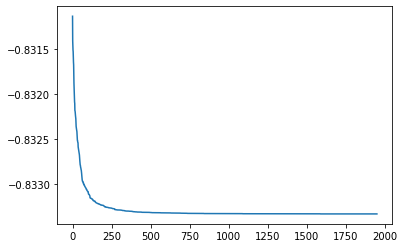

In [43]:
# Qua guardiamo i dati grezzi

plt.plot(s.simulations[11].data['u'][:])
plt.show()

In [ ]:
# Qua guardiamo l'energia al variare di beta

DISCARD = 10000 # MOLTO IMPORTANTE SETTARLO BENE GUARDANDO IL GRAFICO SOPRA
#for simul in s.simulations:
#    pprint(simul.kwargs)
"""
energy_data = {
    simul.kwargs['b']: (
        np.mean(simul.data['u'][DISCARD:]),
        sim.bootstrap(simul.data['u'][DISCARD:]),
    )
    for simul in s.simulations
}
energy_data = sorted(energy_data)
"""
bbb = [float(simul.kwargs['b']) for simul in s.simulations]
print(bbb)
energies = [np.mean(simul.data['u'][DISCARD:])+int(simul.kwargs['f'])/2/float(simul.kwargs['b']) for simul in s.simulations]
unc = [sim.bootstrap(simul.data['u'][DISCARD:]) for simul in s.simulations]
new_energies = []
for simul in s.simulations:
    def get_e(positions):
        e = positions[:,1:] - positions[:,:-1]
        return e, u
#print("AAA", energies, unc)
fig = plt.figure(figsize=(6,4))
plt.errorbar(bbb, energies, unc, fmt="rx")
fig.get_axes()[0].set_xscale('log')
plt.title('Energy vs beta with {} fragments'.format(s.simulations[0].kwargs['f']))
plt.xlabel('$\\beta$'); plt.ylabel('Energy')
#plt.ylim([-0.07, 0])
plt.show()

In [ ]:
# Qua guardiamo le posizioni

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,8))
fig.tight_layout()
for i, simul in enumerate(sorted(s.simulations, key=lambda x: float(x.kwargs['b']))):
    axes.flatten()[i].set_title('$\\beta$ is {}'.format(simul.kwargs['b']))
    axes.flatten()[i].hist(simul.data['x'][DISCARD:,:].flatten(), bins=100)

fig.show()

In [ ]:
# Ora vediamo il gap con il primo eccitato
# Qualcosa di ordinato
simuls = sorted(s.simulations, key=lambda x: float(x.kwargs['b']))[0:]

# L'osservabile magico è <0|x(t)x(0)|0>, da fittare con a+b*exp(-gap*t) con gap*t>>1 (ma lo verifichiamo a posteriori)
T = 2 # t = T/f*beta, abbiamo fatto variare beta. 
       # Vogliamo infatti che T<<f per non essere influenzati dalla periodicità.
       # Ma anche T>>1 per non essere influenzati da carenze della descrizione UV.
t_array = []
magic_array = []
for simul in simuls:
    # Per ogni valore di t mettiamo in magic_array il valore misurato dell'osservabile magic
    x_t = simul.data['x'][:,T:]
    x_0 = simul.data['x'][:,:-T]
    t = T/float(simul.kwargs['f'])*float(simul.kwargs['b']); t_array.append(t)
    magic = np.mean((x_t * x_0).flatten()); magic_array.append(magic)
    print("beta={:.0f}, t={}, magic={}".format(float(simul.kwargs['b']), t, magic))
t_array = np.array(t_array)
magic_array = np.array(magic_array)

from scipy.optimize import curve_fit
def mf(xx, b, gap):
    return b*np.exp(-gap*xx)

p0 = .1, 1
popt, pcov = curve_fit(mf, t_array, magic_array, p0)
print(popt, np.sqrt(np.diag(pcov)))

xx = np.linspace(np.min(t_array), np.max(t_array), 500)
yy = mf(xx, *popt)

plt.figure()
plt.semilogy(xx, yy, color="red")
plt.scatter(t_array, magic_array)
#plt.xlim([0,200])
#plt.ylim([0,0.01])
plt.show()
        